Show the daily PowerSpectralDensities over the course of a year

## Load Libraries

In [1]:
from obspy import * 
from pandas import *
from os import listdir
from datetime import datetime

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
host = os.uname()[1]
if host == "kilauea":
    homepath = "/import/kilauea-data/"
    out_figs = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"
elif host == "lighthouse":
    homepath = "/home/andbro/kilauea-data/"
    out_figs = "/home/andbro/Documents/ROMY/LowNoiseModel/figures/"

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero, zeros
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [5]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

## Configurations

In [6]:
config = {}

config['datadir'] = f"{homepath}ROMY/RotationSpectra/data/"

config['outdir_figures'] = out_figs

config['station'] = "RLAS"
config['year'] = "2019"


## Load Data

In [7]:
path = f"{config['datadir']}run_{config['year']}_{config['station']}-Z_3600_hours/"
file = f"run_{config['year']}_{config['station']}-Z_3600_hours_psds_filtered_medians.pkl"
dataset = read_pickle(path+file)

periods = np.zeros(len(dataset['frequencies']))
periods[:-1] = 1/dataset['frequencies'][1:]

doys = array([int(datetime.strptime(str(date),'%Y%m%d').strftime('%j')) for date in dataset['times']])

## Plots

In [8]:
def __makeplot_colorlines(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array, zeros, linspace
    from scipy.stats import median_abs_deviation as mad
    
   
        
    ff = 1/ff
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 14

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

    ax.loglog(ff, __get_median_psd(array(psds)), 'black', zorder=3, alpha=0.9, label="median")
#     ax.loglog(ff, __get_minimal_psd(array(psds)), 'grey', zorder=3, alpha=1.0, label="minimal")
#     ax.loglog(ff, __get_minimum_psd(array(psds), ff), 'grey', zorder=2, alpha=1.0, label="minimal")
    
    ax.legend()
    
    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    if config['station'] == "ROMY":
        ax.set_ylim(7e-23, 3e-18)
    elif config['station'] == "RLAS":
        ax.set_ylim(1e-24, 1e-18)

    ax.set_xlim(1, 200)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
#     new_ticks=[]
#     for n, t in enumerate(cbar.get_ticks()):
#         print(n)
#         new_ticks.append(columns[int(t)])
#     print(new_ticks)
#     cbar.ax.set_xticklabels(columns)

    ax.set_title(f"{config['station']}  {config['year']}  [{len(psds)}]", fontsize=font-1)

    plt.show();
    return fig

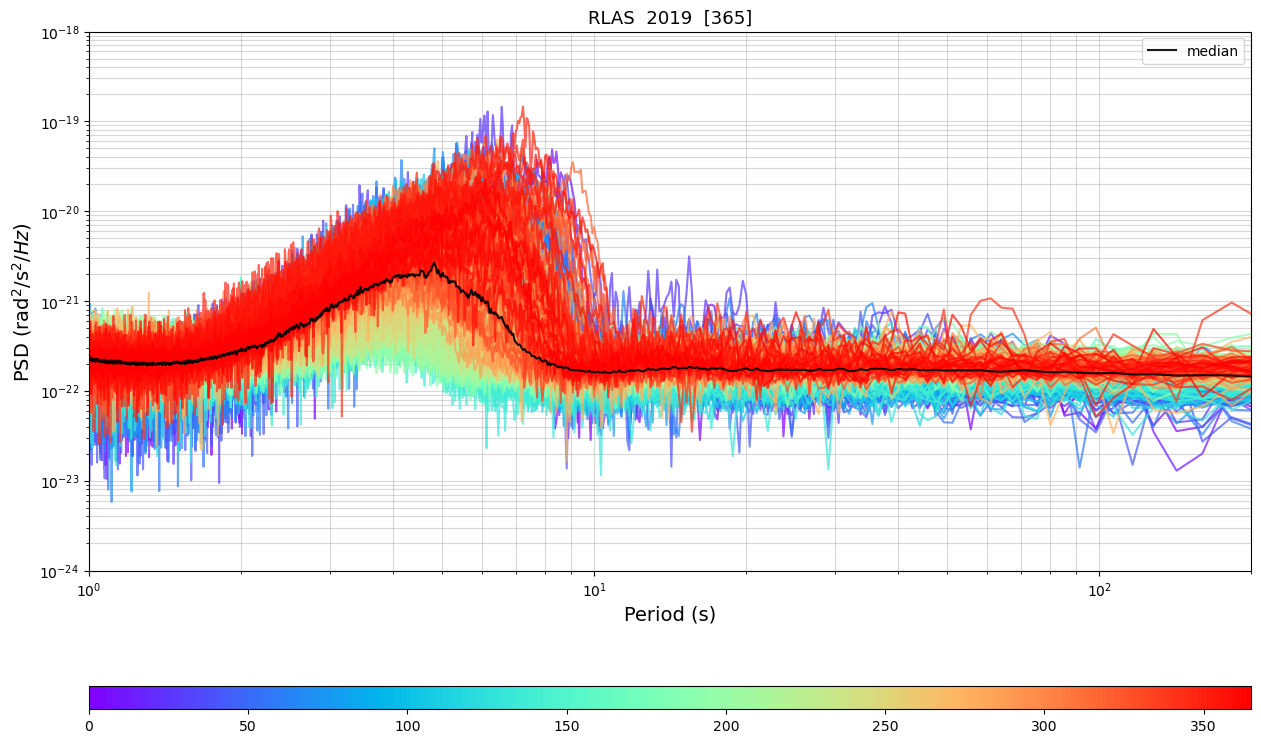

In [9]:
fig = __makeplot_colorlines(config, dataset['frequencies'], dataset['psds_medians'], dataset['times'])

In [10]:
# fig.savefig(config['outdir_figures']+config['station']+config['year']+config['stats']+"PSD_yearly_lines"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

In [11]:
def __makeplot_image(x_axis, y_axis, arr):

    from matplotlib import colors

    maximas = [np.argmax(psd[:1280]) for psd in arr]
    freqs = dataset['frequencies'][maximas]

    font = 12 

    fig, ax  = plt.subplots(1,1, figsize=(15,5))

    cmap = plt.cm.get_cmap('magma')
    cmap.set_under(color='black')
    cmap.set_over(color='white')

    im = plt.pcolor(x_axis, y_axis, arr.T, 
                    cmap=cmap,
    #                 vmin=np.min(np.min(arr[np.nonzero(arr)])),
                    vmax=3e-20,
                    vmin=1e-22,
                    norm=colors.LogNorm(),
                    )

    ## plot maximas
#     ax.scatter(x_axis+0.5, 1/freqs, s=40, c="white")

    ax.set_yscale("log")

    ax.set_title(f"{config['station']} PSD of {config['year']}", fontsize=font+1, pad=0.3)
    ax.set_xlabel(f"Days of {config['year']}", fontsize=font)
    ax.set_ylabel("Period (s)", fontsize=font)
#     ax.set_xticklabels(dataset['times'].astype(str))

    ax.set_ylim(1, 300)

    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    cb.set_label(r"Power Spectral Density ($\frac{rad^2}{s^2 Hz}$)", fontsize=font)

    plt.show();
    return fig

ValueError: Passing a Normalize instance simultaneously with vmin/vmax is not supported.  Please pass vmin/vmax directly to the norm when creating it.

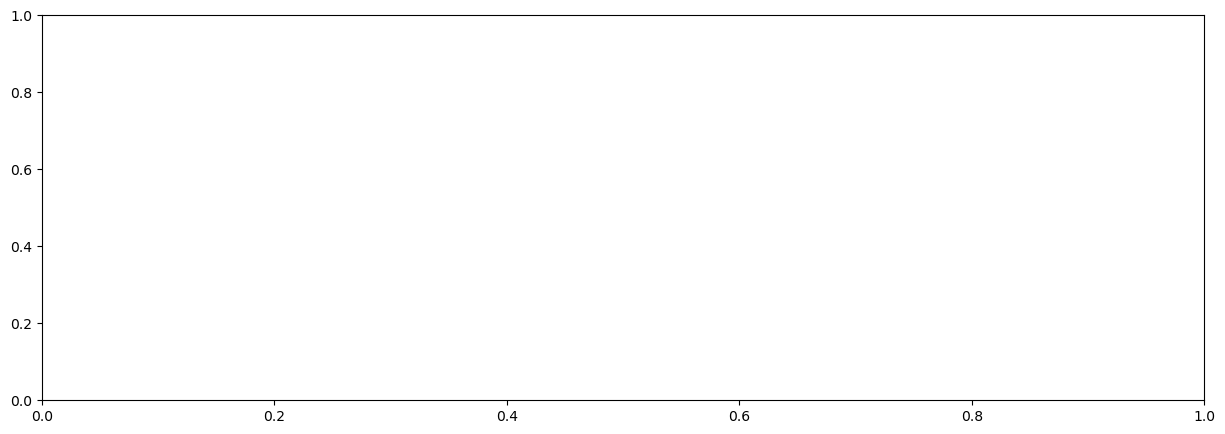

In [12]:
fig = __makeplot_image(doys, periods, dataset['psds_medians'])

In [ ]:
# fig.savefig(config['outdir_figures']+config['station']+config['year']+config['stats']+"PSD_yearly"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

In [ ]:
# fig = __makeplot_image(doys[60:90], periods, dataset['psds_medians'][60:90])